In [1]:
import os
import sys
import string
import pickle
import tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import ldamodel, Phrases, phrases
from gensim import corpora
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer

%matplotlib inline
pd.set_option('display.max_info_columns',200)
pd.set_option('display.max_colwidth',200)
pd.set_option('display.max_rows', 100)
plt.style.use('ggplot')

stemmer = SnowballStemmer("english")
tokenizer = TweetTokenizer()

In [3]:
for f in os.listdir('model_files/'):
        if f.endswith('.gz'):
            tar = tarfile.open('model_files/' + f, "r:gz")
            tar.extractall(path='model_files/')
            tar.close()

# load model, corpus, and dictionary objects
fnames = [fn for fn in os.listdir('model_files/') if '.gensim' in fn]
model = ldamodel.LdaModel.load('model_files/' + fnames[0])
corpus = corpora.MmCorpus('model_files/' + 'unigrams_corpus.mm')
dictionary = corpora.Dictionary.load('model_files/' + 'unigrams_dictionary.pkl')
model.id2word = dictionary
phraser = phrases.Phraser.load('model_files/document_phraser.pkl')

#cleanup the unzipped files
for f in fnames:
    os.remove('model_files/' + f)

In [4]:
model, corpus, dictionary, phraser

(<gensim.models.ldamulticore.LdaMulticore at 0x145f3f6a0>,
 <gensim.models.phrases.Phraser at 0x124268550>)

In [6]:
df = pd.read_csv('model_files/valence_arousal.csv', header=0, index_col=0, sep=',')
keep = ['Word','V.Mean.Sum','V.SD.Sum', 'A.Mean.Sum','A.SD.Sum']
remove = [col for col in df.columns.tolist() if col not in set(keep)]
df = df.drop(remove, axis=1)
df

,Word,V.Mean.Sum,V.SD.Sum,A.Mean.Sum,A.SD.Sum
1,aardvark,6.26,2.21,2.41,1.40
2,abalone,5.30,1.59,2.65,1.90
3,abandon,2.84,1.54,3.73,2.43
4,abandonment,2.63,1.74,4.95,2.64
5,abbey,5.85,1.69,2.20,1.70
6,abdomen,5.43,1.75,3.68,2.23
7,abdominal,4.48,1.59,3.50,1.82
8,abduct,2.42,1.61,5.90,2.57
9,abduction,2.05,1.31,5.33,2.20
10,abide,5.52,1.75,3.26,2.22


In [7]:
df['word_stemmed'] = df['Word'].apply(stemmer.stem)
df

,Word,V.Mean.Sum,V.SD.Sum,A.Mean.Sum,A.SD.Sum,word_stemmed
1,aardvark,6.26,2.21,2.41,1.40,aardvark
2,abalone,5.30,1.59,2.65,1.90,abalon
3,abandon,2.84,1.54,3.73,2.43,abandon
4,abandonment,2.63,1.74,4.95,2.64,abandon
5,abbey,5.85,1.69,2.20,1.70,abbey
6,abdomen,5.43,1.75,3.68,2.23,abdomen
7,abdominal,4.48,1.59,3.50,1.82,abdomin
8,abduct,2.42,1.61,5.90,2.57,abduct
9,abduction,2.05,1.31,5.33,2.20,abduct
10,abide,5.52,1.75,3.26,2.22,abid


In [8]:
n = len(dictionary.items())
v_mean = np.zeros(n)
v_sd = np.zeros(n)
a_mean = np.zeros(n)
a_sd = np.zeros(n)
word_map = {v:k for k,v in dictionary.items()}

for word in df.word_stemmed.unique():
    if word in set(word_map.keys()):
        if df[df.word_stemmed == word].shape[0] > 1:
            v_mean[word_map[word]] = np.average(df[df.word_stemmed == word]['V.Mean.Sum'])
            a_mean[word_map[word]] = np.average(df[df.word_stemmed == word]['A.Mean.Sum'])
            v_sd[word_map[word]] = np.sqrt(np.average(np.power(df[df.word_stemmed == word]['V.SD.Sum'], 2)))
            a_sd[word_map[word]] = np.sqrt(np.average(np.power(df[df.word_stemmed == word]['A.SD.Sum'], 2)))
        else:
            v_mean[word_map[word]] = df[df.word_stemmed == word]['V.Mean.Sum']
            a_mean[word_map[word]] = df[df.word_stemmed == word]['A.Mean.Sum']
            v_sd[word_map[word]] = df[df.word_stemmed == word]['V.SD.Sum']
            a_sd[word_map[word]] = df[df.word_stemmed == word]['A.SD.Sum']

In [9]:
topics = model.get_topics()
topics.shape

(60, 658846)

In [10]:
total_v_sd = np.array([np.sum(v_sd)]*n)
total_a_sd = np.array([np.sum(a_sd)]*n)
valence_mat = topics*(v_mean*(total_v_sd-v_sd)/total_v_sd)
arousal_mat = topics*(a_mean*(total_a_sd-a_sd)/total_a_sd)
topic_valence = np.sum(valence_mat, axis=1)
topic_arousal = np.sum(arousal_mat, axis=1)

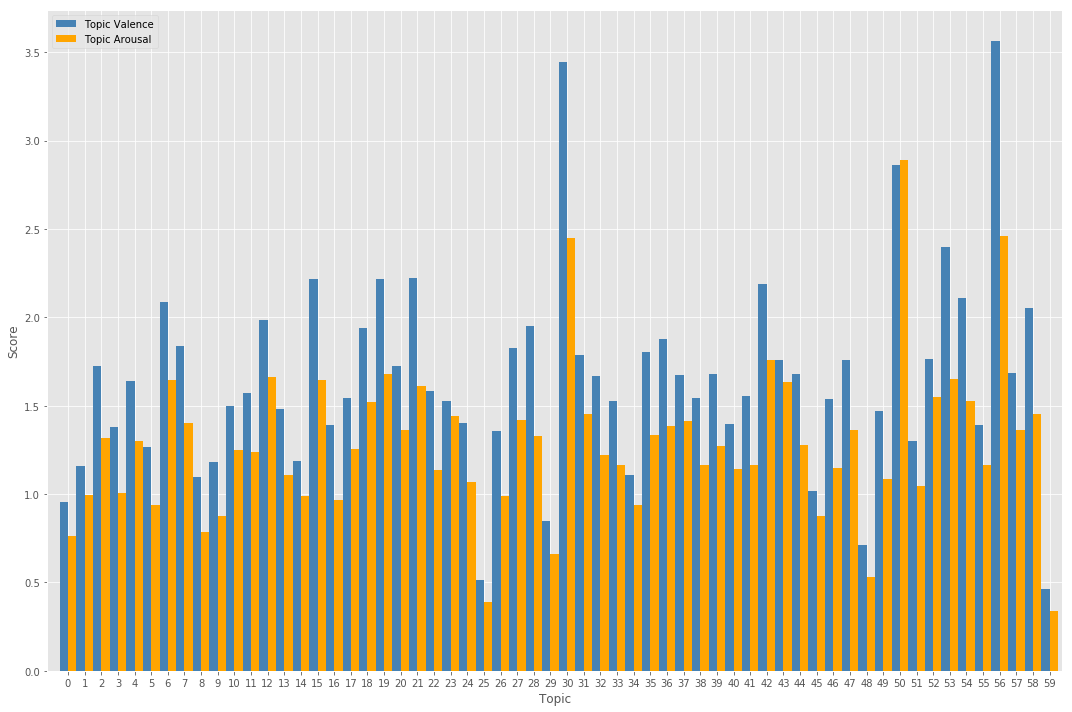

In [15]:
index = np.arange(60)
bar_width = 0.5
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

rects1 = plt.bar(index, topic_valence, bar_width,
                 color='steelblue',
                 label='Topic Valence')

rects2 = plt.bar(index+bar_width, topic_arousal, bar_width,
                 color='orange',
                 label='Topic Arousal')

plt.xlim(-1,60)

plt.xlabel('Topic')
plt.ylabel('Score')
plt.xticks(index + bar_width / 2, index)
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
pickle.dump(v_mean, open('model_files/valence_mean.pkl', 'wb'))
pickle.dump(a_mean, open('model_files/arousal_mean.pkl', 'wb'))
pickle.dump(v_sd, open('model_files/valence_sd.pkl', 'wb'))
pickle.dump(a_sd, open('model_files/arousal_sd.pkl', 'wb'))

In [14]:
os.chdir('model_files/')
tar = tarfile.open('unigrams_corpus.gz', 'w:gz')
for f in ['unigrams_corpus.mm','unigrams_corpus.mm.index']:
    tar.add(f)
tar.close()
os.chdir('..')

In [ ]:
outrage_set = set(outrage_list)
for j in range(len(df_base)):
    if j%25000 == 0:
        print j
    common = outrage_set & df_base.iloc[j,'text_stem'] # not sure on this one might need the column number for text_stem
    count = 0
    for i in df_base.text_stem[j]:
        if i in common:
            count += 1
    df_base['num_outrage_words'][j]= count

In [49]:
one = [1,2,3,4,5,6,7,8,9] # outrage words
two = [1,2,1,10,20,30] # new tweet
common = set(one) & set(two)
counts = 0
for item in two:
    if item in common:
        counts += 1
counts

3

In [51]:
topics = model.print_topics(num_topics=60, num_words=30)

In [59]:
l = [(float(x.split('*')[0]),x.split('*')[1][1:-1]) for x in topics[0][1].split(" + ")]
l

[(0.332, 'global_warm'),
 (0.013, 'new_york'),
 (0.013, '...'),
 (0.009, 'via_@dailycal'),
 (0.009, 'time'),
 (0.008, 'caus'),
 (0.007, 'predict'),
 (0.005, 'hoax'),
 (0.004, 'climat_chang'),
 (0.004, 'theori'),
 (0.004, 'excit'),
 (0.004, '#isi'),
 (0.004, 'obama'),
 (0.004, '#tcot'),
 (0.004, 'antarct_ice'),
 (0.003, '#forecast'),
 (0.003, 'develop'),
 (0.003, 'say'),
 (0.003, 'claim'),
 (0.003, 'crowd'),
 (0.003, 'trend'),
 (0.003, 'summer'),
 (0.003, 'gain_ice'),
 (0.003, 'send_forc'),
 (0.003, 'metorologist_fight'),
 (0.003, 'https://t.co/gprzfbifbm_obama'),
 (0.003, 'new'),
 (0.003, 'denial'),
 (0.003, 'enrich_famili'),
 (0.003, 'speed')]

In [66]:
'''for w in l:
    print(list('global' in w[1]))'''
    
booleans = np.sum([('global' in w[1]) for w in l])

In [68]:
np.sum(booleans)

1

In [70]:
tweet = [w[1] for w in l]
tweet

['global_warm',
 'new_york',
 '...',
 'via_@dailycal',
 'time',
 'caus',
 'predict',
 'hoax',
 'climat_chang',
 'theori',
 'excit',
 '#isi',
 'obama',
 '#tcot',
 'antarct_ice',
 '#forecast',
 'develop',
 'say',
 'claim',
 'crowd',
 'trend',
 'summer',
 'gain_ice',
 'send_forc',
 'metorologist_fight',
 'https://t.co/gprzfbifbm_obama',
 'new',
 'denial',
 'enrich_famili',
 'speed']

In [71]:
np.sum([('global' in w) for w in tweet])

1